<a href="https://colab.research.google.com/github/wangjh789/2021-2_BigData/blob/master/compare_sort.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget https://dlcdn.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz 
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
!pip install findspark
!pip install pyspark
!pip install numpy

--2021-11-04 11:05:30--  https://dlcdn.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 224445805 (214M) [application/x-gzip]
Saving to: ‘spark-3.1.2-bin-hadoop2.7.tgz’

spark-3.1.2-bin-had 100%[===================>] 214.05M   189MB/s    in 1.1s    

2021-11-04 11:05:45 (189 MB/s) - ‘spark-3.1.2-bin-hadoop2.7.tgz’ saved [224445805/224445805]

     |████████████████████████████████| 281.3 MB 39 kB/s 
     |████████████████████████████████| 198 kB 51.2 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=4442e9e1f0070f11dae1e31210ba9626fdcb2ba50678c263955f22b48df8ce35
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

import findspark
findspark.init()
from pyspark import SparkContext


sc = SparkContext("local[10]","temp2")

In [6]:
import time

In [7]:
input_rdd = sc.textFile('./drive/MyDrive/pagerank_data.txt')

In [4]:
BLOCK_SIZE = [16,8,4,2,1]
PATH = ["./drive/MyDrive/inverted_list.txt","./drive/MyDrive/sorted_asc.txt","./drive/MyDrive/sorted_desc.txt"]
MAX_ITER_COUNT = 20
HYPER_PARAMETER = 0.85
time_result = []
CONVERGENCE_TOL = 0.0001

In [100]:
data = []

f = open('./drive/MyDrive/pagerank_data.txt', 'r')
while True:
    line = f.readline()
    if not line:
        break
    temp = line.split(' ')
    data.append((int(temp[0]), [int(i) for i in temp[1:]]))

In [101]:
input_rdd = input_rdd.map(lambda x : [int(y) for y in x.split(' ')]).map(lambda x : (x[0],x[1:]))

In [102]:
def generate_data(path):
  # './drive/MyDrive/inverted_list.txt'
  data1 = []
  f = open(path, 'r')
  while True:
      line = f.readline()
      if not line:
          break
      temp = line.split(' ')

      if temp[-1] == '':
          data1.append((int(temp[0]),[]))
      else:
          data1.append((int(temp[0]), [int(i) for i in temp[1:]]))
  return data1


In [103]:
time_result = []
each_size = sc.broadcast([len(d[1]) for d in data])
for path in PATH:
	for BLOCK in BLOCK_SIZE:
		data1 = generate_data(path)
		
		EACH_BLOCK_SIZE = len(data) // BLOCK
		test = [sc.parallelize(data1[b*EACH_BLOCK_SIZE:(b+1)*EACH_BLOCK_SIZE]) for b in range(BLOCK)]

		time_start = time.time()
		for trial in range(3):
			
			p_i = sc.broadcast([1/30000 for _ in range(30000)])
			print(f'{path} ,BLOCK SIZE : {BLOCK}, {trial}번째 시작')
			for j in range(MAX_ITER_COUNT):
				temp_p_i = [(1-HYPER_PARAMETER)/30000 for _ in range(30000)]
				iter_time_start = time.time()
				err = 0
				for t in test:
					key_pair = t.flatMap(lambda x:[ (x[0],p_i.value[i] / each_size.value[x[0]]) for i in x[1]])
					new_p_i = key_pair.reduceByKey(lambda x,y : x+y)
					post_process_p_i = new_p_i.map(lambda x : (x[0],HYPER_PARAMETER*x[1] + (1-HYPER_PARAMETER)/30000))
					result = post_process_p_i.collect()

					for r in result:
						temp_p_i[r[0]] = r[1]

				err += sum([abs(p_i.value[i] - temp_p_i[i]) for i in range(30000)])

				if err < CONVERGENCE_TOL:
					break
				print("======================================================================================================================")
				print(f'{path} ,BLOCK SIZE : {BLOCK}, {trial}번째, {j+1}th iteration')
				print(f'takes {time.time()-iter_time_start}seconds, ERR : {err}')
				print(temp_p_i[:5])
				print("======================================================================================================================")

				p_i = sc.broadcast(temp_p_i)

		time_result.append([(time.time()-time_start)/3])

./drive/MyDrive/inverted_list.txt ,BLOCK SIZE : 16, 0번째 시작
./drive/MyDrive/inverted_list.txt ,BLOCK SIZE : 16, 0번째, 1th iteration
takes 42.89464974403381seconds, ERR : 1.0219486458462346
[5e-06, 0.0008541508491511088, 0.0008541508491511088, 0.000853303393213556, 0.000853303393213556]
./drive/MyDrive/inverted_list.txt ,BLOCK SIZE : 16, 0번째, 2th iteration
takes 41.81096529960632seconds, ERR : 0.037013493829941575
[5e-06, 0.0008541541519203593, 0.0008541541519203593, 0.0008533066926869475, 0.0008533066926869475]
./drive/MyDrive/inverted_list.txt ,BLOCK SIZE : 16, 0번째, 3th iteration
takes 42.060494899749756seconds, ERR : 0.0008227230154214779
[5e-06, 0.0008541542462547997, 0.0008541542462547997, 0.0008533067869272048, 0.0008533067869272048]
./drive/MyDrive/inverted_list.txt ,BLOCK SIZE : 16, 1번째 시작
./drive/MyDrive/inverted_list.txt ,BLOCK SIZE : 16, 1번째, 1th iteration
takes 41.73944091796875seconds, ERR : 1.0219486458462346
[5e-06, 0.0008541508491511088, 0.0008541508491511088, 0.0008533033

In [104]:
result = []
for i in time_result:
  result.append(i[0])

In [113]:
import matplotlib.pyplot as plt
import numpy as np
invert_time = result[:len(BLOCK_SIZE)]
asc_time = result[len(BLOCK_SIZE):len(BLOCK_SIZE)*2]
desc_time = result[len(BLOCK_SIZE)*2:]

# temp_x = np.arange(len(BLOCK_SIZE))

# plt.bar(temp_x-0.0,[invert_time[0],asc_time[0],desc_time[0]],width=0.2,color='orange',label='16 block')
# plt.bar(temp_x+0.2,[invert_time[1],asc_time[1],desc_time[1]],width=0.2,color='blue',label='1 block')
# plt.xticks(temp_x+0.1,["invert","asc","desc"])
# plt.legend(loc=3)
# plt.xlabel("sorting method")
# plt.ylabel("time according to data sort")
# plt.show()

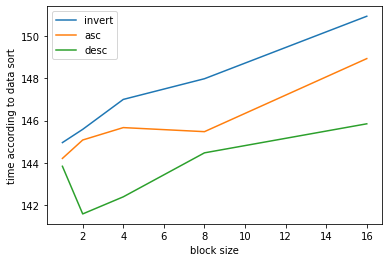

In [9]:
import matplotlib.pyplot as plt

plt.plot(BLOCK_SIZE, invert_time,label="invert")
plt.plot(BLOCK_SIZE, asc_time,label="asc")
plt.plot(BLOCK_SIZE, desc_time,label="desc")
plt.xlabel("block size")
plt.ylabel("time according to data sort")
plt.legend()
plt.show()